Here we pair deflectors on the MFP and make PDSPLs

In [7]:
# Standard imports
import copy
import corner
import numpy as np
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
from itertools import combinations
from IPython.display import display, Markdown, Math
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.cosmology import FlatLambdaCDM
from scipy.stats import norm


# Astropy imports
from astropy.io import fits
from astropy import units as u
from astropy.table import Table
from astropy.units import Quantity
from astropy import constants as const

# SLSim imports
import slsim.Pipelines as pipelines
import slsim.Sources as sources
import slsim.Deflectors as deflectors
from slsim.Lenses.lens_pop import LensPop
from slsim.Plots.lens_plots import LensingPlots
from slsim.Lenses.lens import Lens
from slsim.LOS.los_pop import LOSPop

# Lenstronomy, HierArc imports
from lenstronomy.LensModel.lens_model import LensModel
from hierarc.Sampling.ParamManager.cosmo_param import CosmoParam

from utils import fit_plane, find_scatter, run_pairing_simulation_from_data, pdspl_pairing_table_from_valid_pairs_table

In [8]:
# load the GGL data tables with 1000 deg^2 sky area of lens systems but galaxy population is on 10 deg^2
sky_area = "5000.0"
GGL_data_table = Table.read(f"../data/GGL_{sky_area}_SQDEG.fits", format='fits')

GGL_data_table

lens_id,z_D,z_S,theta_E,sigma_v_D,stellar_mass_D,mag_S_i,mag_S_r,mag_S_g,mag_S_z,mag_S_y,mag_D_i,mag_D_r,mag_D_g,mag_D_z,mag_D_y,size_D,e1_mass_D,e2_mass_D,e_mass_D,gamma_pl,R_e_kpc,Sigma_half_Msun/pc2,surf_bri_mag/arcsec2
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64
0,0.18128125534860448,1.0957316316483503,1.559552674088125,261.7418766222808,510208601210.7227,27.30208984122244,27.581460455838894,27.89598576248138,26.822040682861953,26.644926127084275,16.25954256397845,16.719695871945177,17.759944172876693,15.99942596408146,15.80979106791338,1.6827477088276492,-0.004002589210209579,0.07124683871176973,0.07135918123694117,2,5.1363913484095685,6179.011740633373,21.353620549667575
1,1.6461110256264142,4.25683755120038,0.5925540235916136,235.56963992911537,390379091508.3477,24.940791075067345,25.1969540378413,26.358258287728027,24.888474026014883,24.764572418155858,24.145590452880448,24.39913024189095,24.47096707143487,23.668001823865247,23.311871090978165,0.5913209870321624,0.158181845889771,-0.04880957837747978,0.1655411468804134,2,5.009158935093517,5102.452953253668,25.81182776257157
2,0.7018574780219449,1.8286872726598518,0.521622006668852,192.15212303141507,220031868018.22354,26.78547625154308,27.00682049021257,27.260615971835882,26.539513823447784,26.464580726090425,20.87114135167255,21.87022825416512,22.849246467398487,20.485271815999297,20.242974915903254,0.7096594627404692,-0.20451267979928908,-0.15179811428816384,0.2546921743990753,2,5.076513449360554,3316.9959496287297,24.61678400482324
3,0.3771217828927475,1.6507694946910063,1.5877768723167107,284.069071509246,688926550632.2189,27.34847300922375,27.549758536975876,27.681685025942084,27.092064023094512,26.78911081313684,17.958253643604504,18.553900008529315,20.065049422447782,17.632951351063166,17.455317379633886,1.1107751465625362,-0.01897032945366259,0.11668817282834308,0.1182201466654384,2,5.7547573707992115,6481.7737097569425,22.756939185989026
4,0.4992084355727959,3.161498679692048,0.9567126432867702,216.1359243673359,309900340847.3288,25.354170355804907,25.503541459263065,25.727086342933188,25.215881933592005,25.19122458805712,19.5103658917246,20.216346109142574,21.367709010780384,19.16476832839017,18.91135306718056,1.1115902537023898,0.008796761968147592,0.005711686228704975,0.010488392665200229,2,6.77964807152321,3196.018497061882,24.0606715980108
5,0.44670737442563785,2.2403077838670176,0.6182583894438882,176.35133159067124,164114327109.73065,23.987539195218687,24.074213837902732,24.20163412566813,23.890087591257142,23.7323237255968,19.830386656329406,20.44988333187086,21.795480254953358,19.511137688407718,19.29029383232294,0.6236752721238379,-0.00834751837384936,0.0361391151225497,0.03709065522261171,2,3.576974033944673,4031.524932511753,23.234258511482487
6,1.0099796617308345,2.4927506795250793,0.5260989688272069,206.42972655637547,272501619672.27655,26.29051654217891,26.52945154504283,26.802942232679722,26.20794571460173,25.95029316061687,22.909576726550057,23.757833749045524,24.60445994880302,21.994722420564422,21.503409109244515,0.45858949963142615,-0.009278470728267497,0.003125885916357121,0.009790872372643644,2,3.681247413890122,5369.247781711603,25.382908602773202
7,1.1687681550638929,2.826650018379998,1.652474103886779,377.3158206388067,1248346834139.14,24.83541503267986,25.134457362799687,25.452658842164396,24.665439748239606,24.499732117354746,21.93123799159734,23.071160777817074,24.234681882369383,21.11700711046006,20.406475017378607,1.0743917444354762,-0.17043015137015502,0.1038174696312703,0.19956077644841355,2,8.87452864700834,7365.066900372805,26.861469550194
8,1.6269287552529557,3.293459208446792,0.6348494170702866,267.81495105239617,541576037565.15216,23.95184989062291,24.04160456650827,24.2675085865084,23.877034858793422,23.83395521167202,23.95566911199722,24.383257422984943,24.50170246296685,23.364550

In [10]:
# fit the MFP
coeffs_MFP = fit_plane(
    np.log10(GGL_data_table["R_e_kpc"]),
    np.log10(GGL_data_table["Sigma_half_Msun/pc2"]),
    np.log10(GGL_data_table["sigma_v_D"])
)

# find the scatter
scatter_MFP = find_scatter(
    np.log10(GGL_data_table["R_e_kpc"]),
    np.log10(GGL_data_table["Sigma_half_Msun/pc2"]),
    np.log10(GGL_data_table["sigma_v_D"]),
    coeffs_MFP,
    return_fit=False
)

coeffs_MFP_alt = fit_plane(
    np.log10(GGL_data_table["sigma_v_D"]),
    np.log10(GGL_data_table["Sigma_half_Msun/pc2"]),
    np.log10(GGL_data_table["R_e_kpc"]),
)

scatter_MFP_alt = find_scatter(
    np.log10(GGL_data_table["sigma_v_D"]),
    np.log10(GGL_data_table["Sigma_half_Msun/pc2"]),
    np.log10(GGL_data_table["R_e_kpc"]),
    coeffs_MFP_alt,
    return_fit=False
)

display(Markdown(f"SLSim MFP: "+"$\\log_{10}(\\sigma_v)$ = " + f"{coeffs_MFP[0]:.2f} * "+"$\\log_{10}(R_e)$"+f" + {coeffs_MFP[1]:.2f} * "+"$\\log_{10}(\\Sigma_{1/2}) + "+f"{coeffs_MFP[2]:.2f}$ " + "$\\Rightarrow \\Delta \\log_{10}(\\sigma_v)$ = " + f"{np.std(scatter_MFP):.3f} dex "+"$\\Rightarrow {\\Delta \\sigma_v}/{\\sigma_v}$: " + f"{np.std(scatter_MFP)*np.log(10)*100:.2f} %"))
display(Markdown(f"SLSim MFP (alt): "+"$\\log_{10}(R_e)$ = " + f"{coeffs_MFP_alt[0]:.2f} * "+"$\\log_{10}(\\sigma_v)$"+f" + {coeffs_MFP_alt[1]:.2f} * "+"$\\log_{10}(\\Sigma_{1/2}) + "+f"{coeffs_MFP_alt[2]:.2f}$ " + "$\\Rightarrow \\Delta \\log_{10}(R_e)$ = " + f"{np.std(scatter_MFP_alt):.3f} dex "+"$\\Rightarrow {\\Delta R_e}/{R_e}$: " + f"{np.std(scatter_MFP_alt)*np.log(10)*100:.2f} %"))

SLSim MFP: $\log_{10}(\sigma_v)$ = 0.50 * $\log_{10}(R_e)$ + 0.50 * $\log_{10}(\Sigma_{1/2}) + 0.17$ $\Rightarrow \Delta \log_{10}(\sigma_v)$ = 0.002 dex $\Rightarrow {\Delta \sigma_v}/{\sigma_v}$: 0.51 %

SLSim MFP (alt): $\log_{10}(R_e)$ = 2.00 * $\log_{10}(\sigma_v)$ + -1.00 * $\log_{10}(\Sigma_{1/2}) + -0.34$ $\Rightarrow \Delta \log_{10}(R_e)$ = 0.004 dex $\Rightarrow {\Delta R_e}/{R_e}$: 1.02 %

In [11]:
# 1 year coadd
# point source depths: g < 26.0, r < 25.7, i < 25.0, z < 24.3, y < 23.1
# extended source depths are 1 mag shallower: g < 25.0, r < 24.7, i < 24.0, z < 23.3, y < 22.1
lsst_1_yr_coadd_mag_depth_mask = (
                        ((GGL_data_table['mag_D_g'] < 25.0) | 
                        (GGL_data_table['mag_D_r'] < 24.7) |
                        (GGL_data_table['mag_D_i'] < 24.0) |
                        (GGL_data_table['mag_D_z'] < 23.3) |
                        (GGL_data_table['mag_D_y'] < 22.1) )
                        
                        &

                        ((GGL_data_table['mag_S_g'] < 25.0) |
                        (GGL_data_table['mag_S_r'] < 24.7) |
                        (GGL_data_table['mag_S_i'] < 24.0) |
                        (GGL_data_table['mag_S_z'] < 23.3) |
                        (GGL_data_table['mag_S_y'] < 22.1))
)

# 10 year coadd
# point source depths: g < 27.4, r < 27.5, i < 26.8, z < 26.1, y < 24.9
# extended source depths are 1 mag shallower: g < 26.4, r < 26.5, i < 25.8, z < 25.1, y < 23.9
lsst_10_yr_coadd_mag_depth_mask = (
                        ((GGL_data_table['mag_D_g'] < 26.4) | 
                        (GGL_data_table['mag_D_r'] < 26.5) |
                        (GGL_data_table['mag_D_i'] < 25.8) |
                        (GGL_data_table['mag_D_z'] < 25.1) |
                        (GGL_data_table['mag_D_y'] < 23.9) )
                        
                        &

                        ((GGL_data_table['mag_S_g'] < 26.4) |
                        (GGL_data_table['mag_S_r'] < 26.5) |
                        (GGL_data_table['mag_S_i'] < 25.8) |
                        (GGL_data_table['mag_S_z'] < 25.1) |
                        (GGL_data_table['mag_S_y'] < 23.9) )
)

# 4MOST spec-z for sources: r < 23.5 and z < 1.5

lsst_4MOST_mag_depth_mask = (
                        (GGL_data_table['mag_D_r'] < 23.5) & (GGL_data_table['mag_S_r'] < 23.5) &
                        (GGL_data_table['z_S'] < 1.5) # 4MOST limit
)


lsst_1_yr_GGL_table = GGL_data_table[lsst_1_yr_coadd_mag_depth_mask]
lsst_10_yr_GGL_table = GGL_data_table[lsst_10_yr_coadd_mag_depth_mask]
lsst_4MOST_GGL_table = GGL_data_table[lsst_4MOST_mag_depth_mask]



print('----------------------------------')
print("Sky area:", sky_area, "deg^2")
print('----------------------------------')
print("Total (g < 28) # lenses:", len(GGL_data_table))
print("Y1  (g < 25.0 | r < 24.7 | i < 24.0)   # lenses:", np.sum(lsst_1_yr_coadd_mag_depth_mask))
print("Y10 (g < 26.4 | r < 26.5 | i < 25.8)   # lenses:", np.sum(lsst_10_yr_coadd_mag_depth_mask))
print("4MOST (r < 23.5 & z_S < 1.5)           # lenses:", np.sum(lsst_4MOST_mag_depth_mask))
print('----------------------------------')
print()
# print('----------------------------------')
# print("Sky area:", 20000, "deg^2")
# print('----------------------------------')
# print("Y1 # lenses:", np.sum(lsst_1_yr_coadd_mag_depth_mask)*20000/float(sky_area))
# print("Y10 # lenses:", np.sum(lsst_10_yr_coadd_mag_depth_mask)*20000/float(sky_area))
# print("4MOST # lenses:", np.sum(lsst_4MOST_mag_depth_mask)*20000/float(sky_area))
# print('----------------------------------')

_, idx_unique_deflectors = np.unique(lsst_1_yr_GGL_table['z_D'], return_index=True)
lsst_1_yr_GGL_table_unique_deflectors = lsst_1_yr_GGL_table[np.sort(idx_unique_deflectors)]
_, idx_unique_deflectors = np.unique(lsst_10_yr_GGL_table['z_D'], return_index=True)
lsst_10_yr_GGL_table_unique_deflectors = lsst_10_yr_GGL_table[np.sort(idx_unique_deflectors)]
_, idx_unique_deflectors = np.unique(lsst_4MOST_GGL_table['z_D'], return_index=True)
lsst_4MOST_GGL_table_unique_deflectors = lsst_4MOST_GGL_table[np.sort(idx_unique_deflectors)]


print('----------------------------------')
print("After removing repeated deflectors:")
print('----------------------------------')
print("Y1  (g < 25.0 | r < 24.7 | i < 24.0)   # lenses:", len(lsst_1_yr_GGL_table_unique_deflectors))
print("Y10 (g < 26.4 | r < 26.5 | i < 25.8)   # lenses:", len(lsst_10_yr_GGL_table_unique_deflectors))
print("4MOST (r < 23.5 & z_S < 1.5)           # lenses:", len(lsst_4MOST_GGL_table_unique_deflectors))
print('----------------------------------')
print()

----------------------------------
Sky area: 5000.0 deg^2
----------------------------------
Total (g < 28) # lenses: 526339
Y1  (g < 25.0 | r < 24.7 | i < 24.0)   # lenses: 60398
Y10 (g < 26.4 | r < 26.5 | i < 25.8)   # lenses: 286789
4MOST (r < 23.5 & z_S < 1.5)           # lenses: 2541
----------------------------------

----------------------------------
After removing repeated deflectors:
----------------------------------
Y1  (g < 25.0 | r < 24.7 | i < 24.0)   # lenses: 20978
Y10 (g < 26.4 | r < 26.5 | i < 25.8)   # lenses: 39900
4MOST (r < 23.5 & z_S < 1.5)           # lenses: 1789
----------------------------------




--- Running simulation for 20978 lenses ---
x_std: 0.2171236915888794, y_std: 0.13216032257264268
Using bin widths of 0.06 in x and 0.04 in y for pairing.
Using 28 bins in x and 28 bins in y for pairing.
Finding pairs in the binned data...
Found 30668 pairs.


/Users/paras/Projects/PDSPL/pdspl-analysis/notebooks/utils.py:221: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta_DSPL = beta_double_source_plane(



--- Running simulation for 39900 lenses ---
x_std: 0.21720665315535687, y_std: 0.1317874102642019
Using bin widths of 0.05 in x and 0.03 in y for pairing.
Using 35 bins in x and 36 bins in y for pairing.
Finding pairs in the binned data...
Found 81750 pairs.


/Users/paras/Projects/PDSPL/pdspl-analysis/notebooks/utils.py:221: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta_DSPL = beta_double_source_plane(



--- Running simulation for 1789 lenses ---
x_std: 0.19328976658970448, y_std: 0.12902458620948315
Using bin widths of 0.10 in x and 0.07 in y for pairing.
Using 14 bins in x and 15 bins in y for pairing.
Finding pairs in the binned data...
Found 675 pairs.


/Users/paras/Projects/PDSPL/pdspl-analysis/notebooks/utils.py:221: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta_DSPL = beta_double_source_plane(


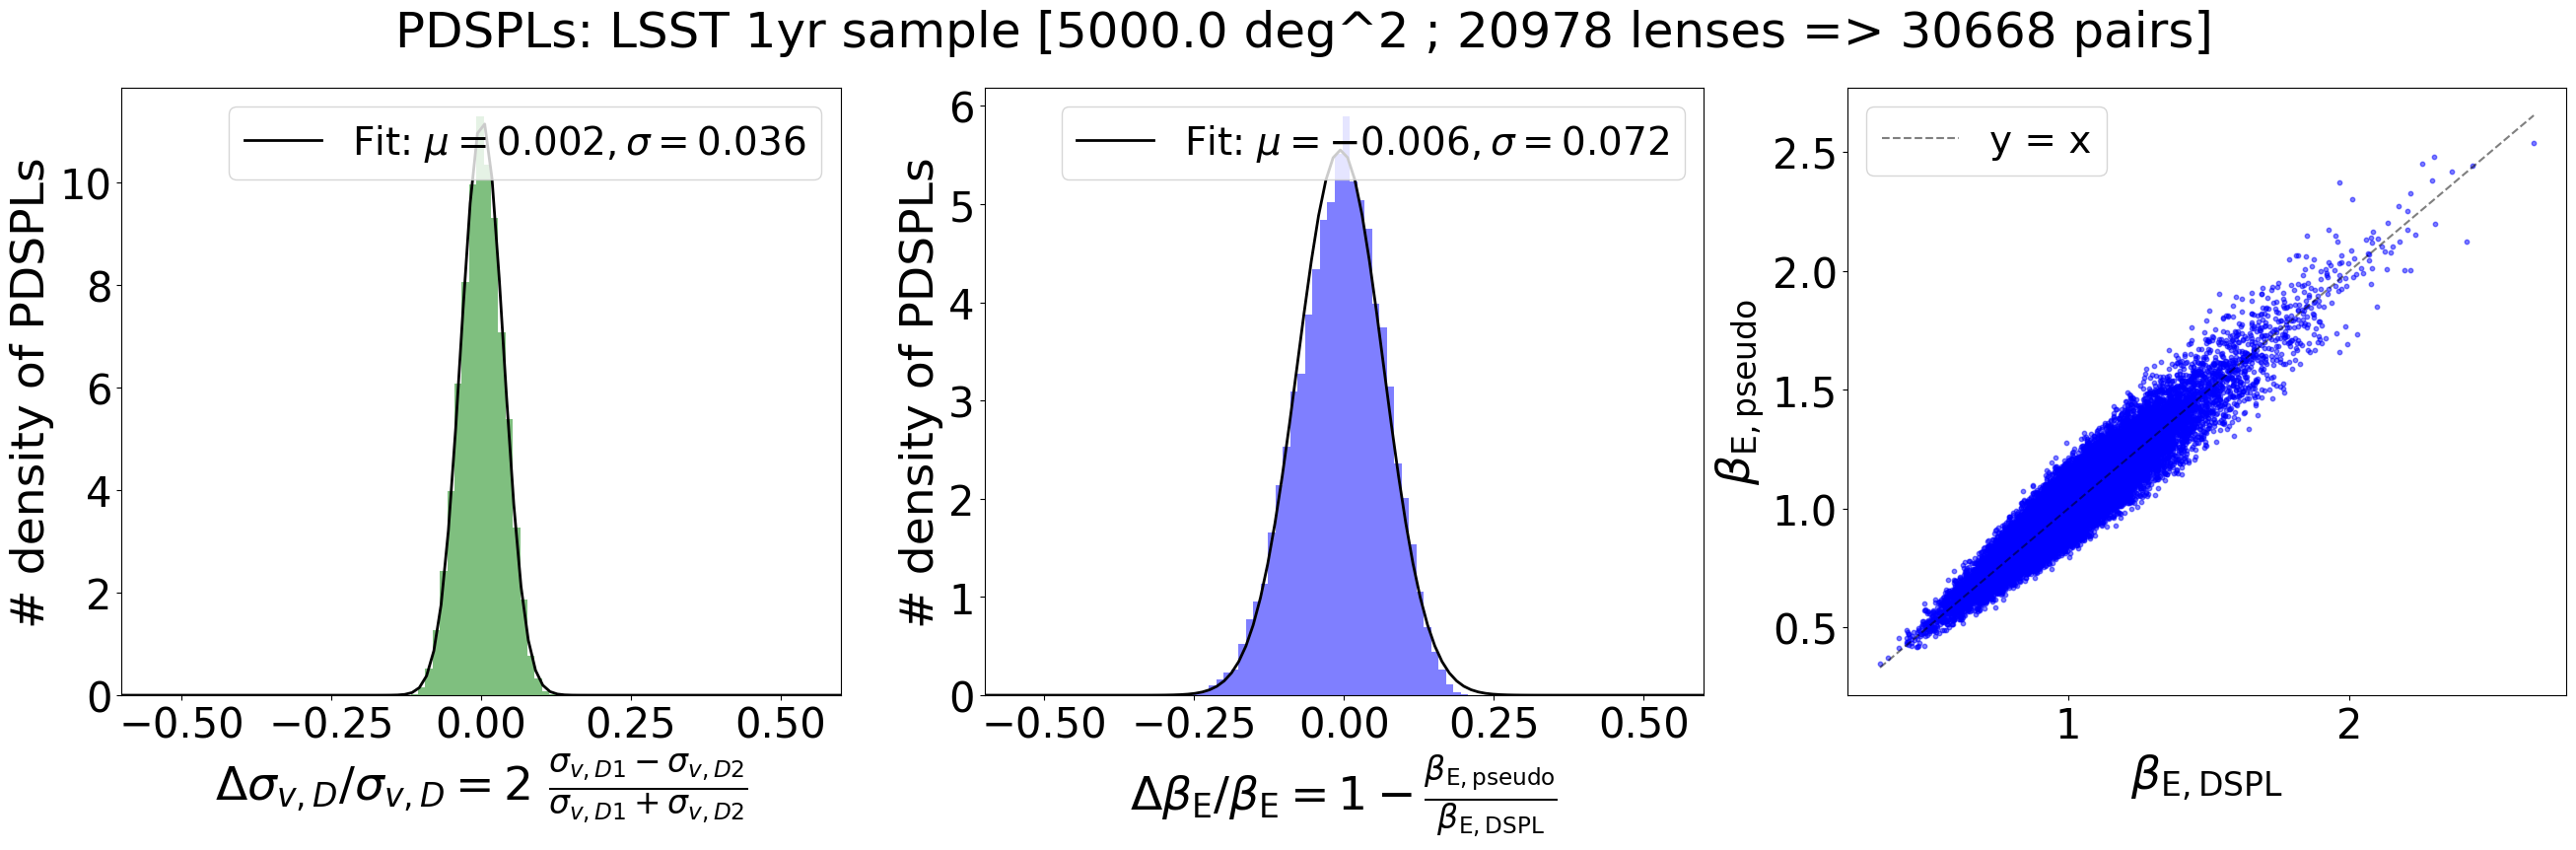

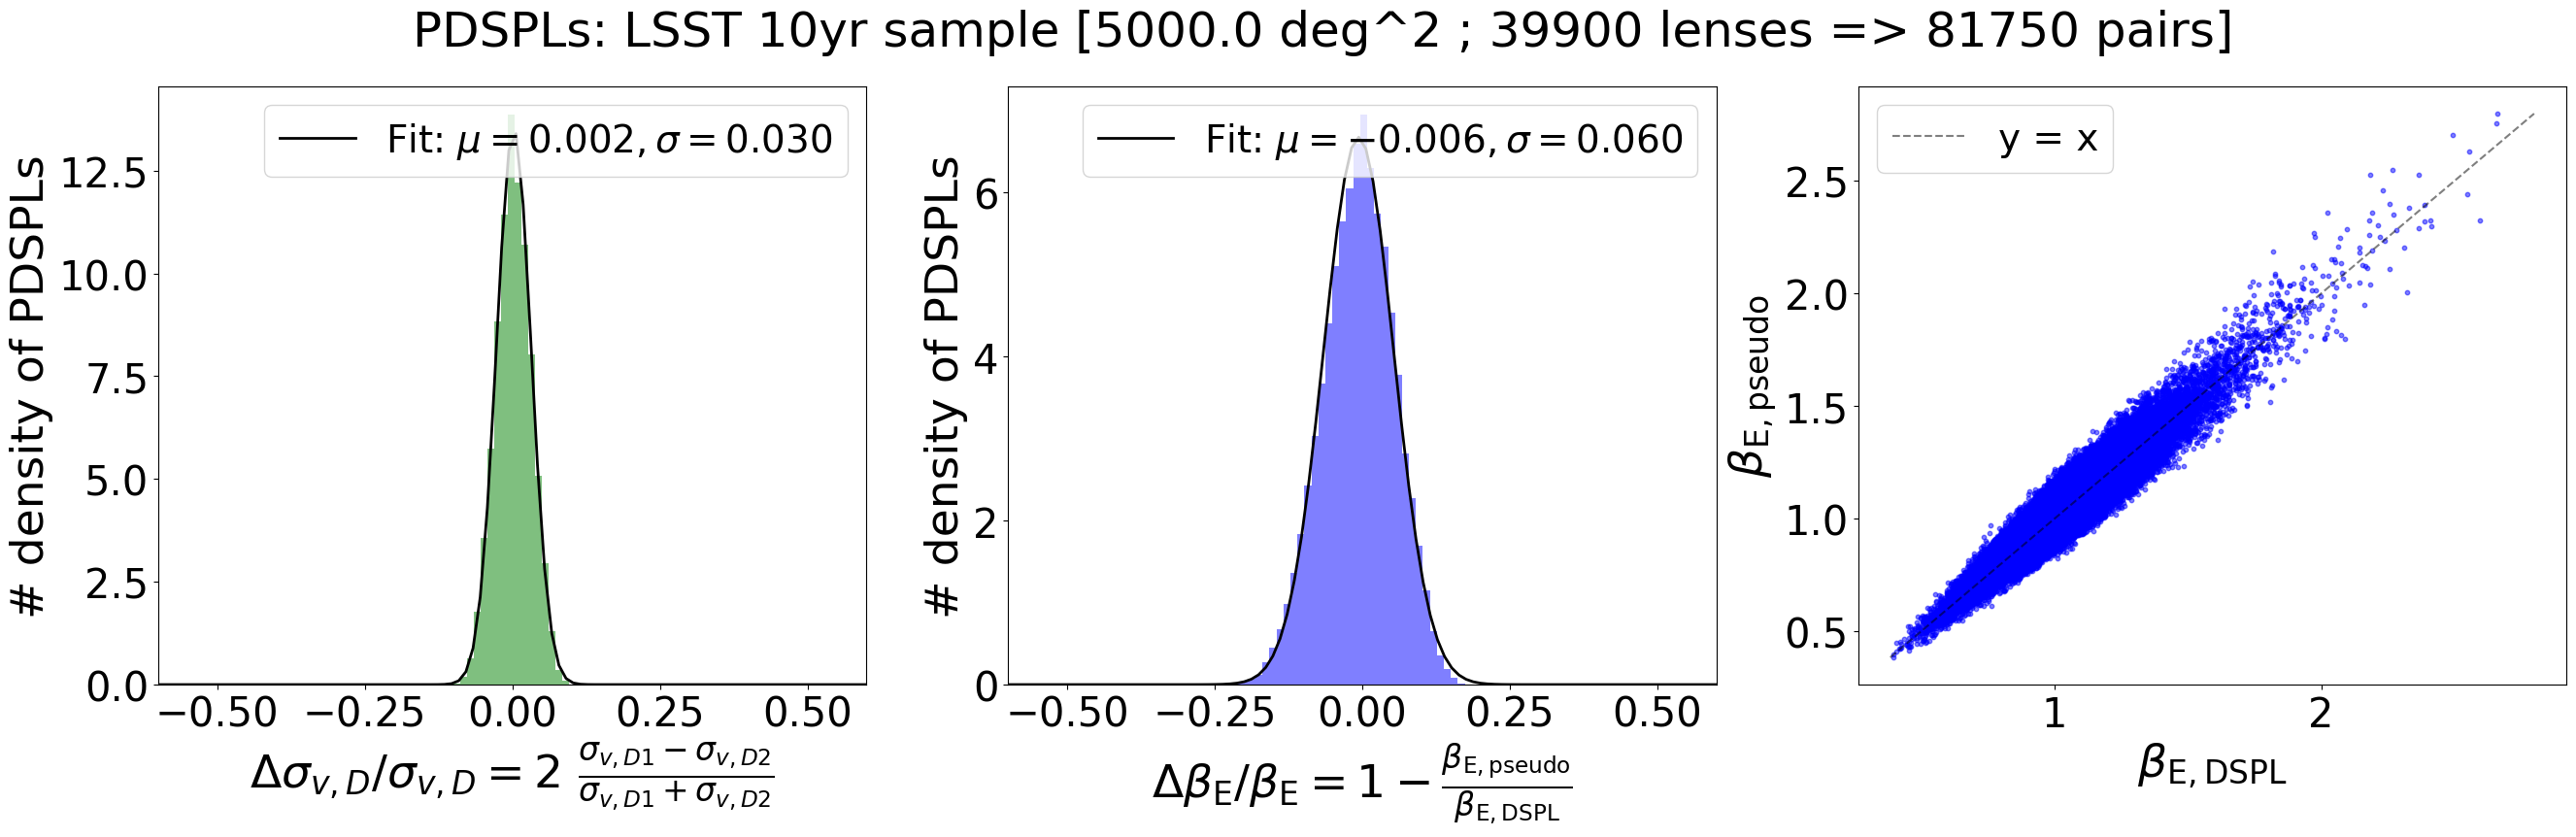

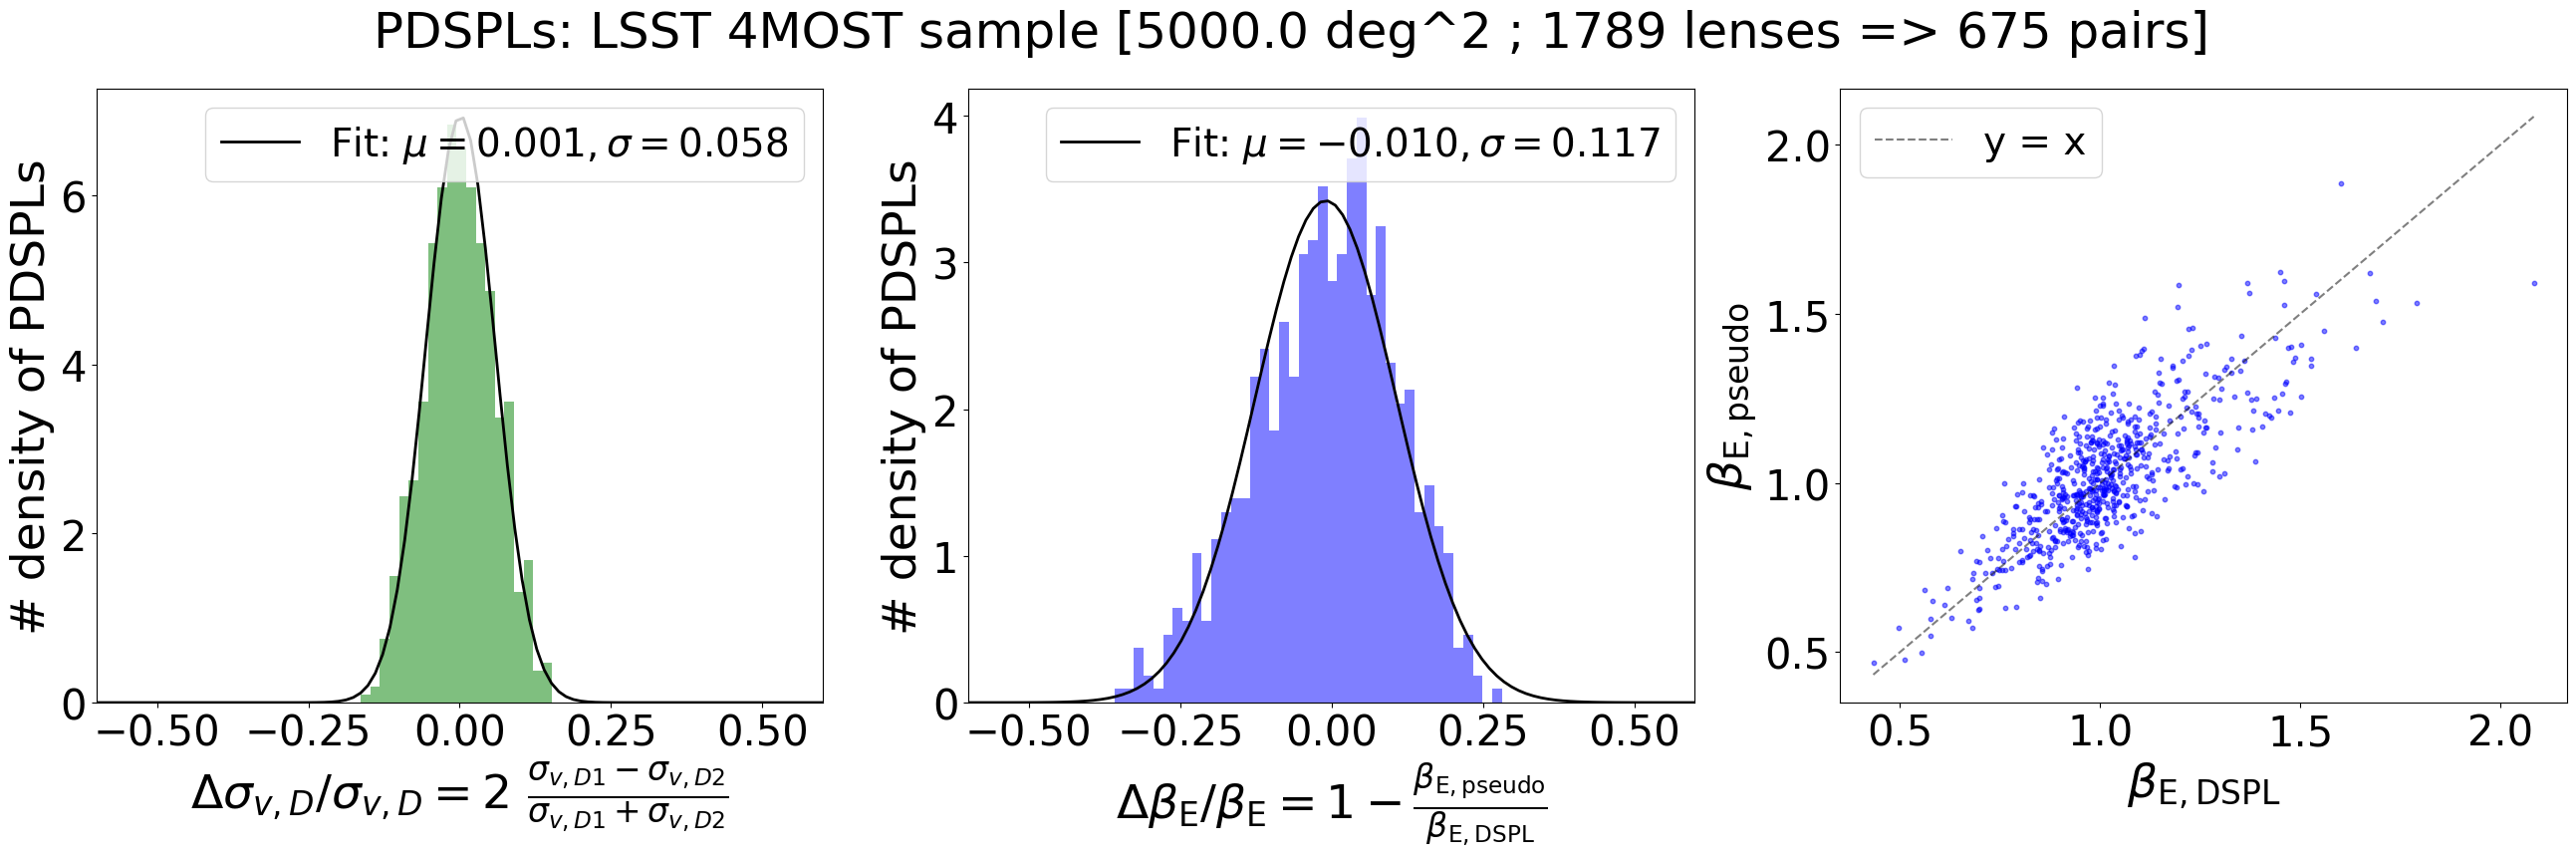

In [12]:
cosmo_true = FlatLambdaCDM(H0=70, Om0=0.3)

data_survey_dict = {}
data_survey_dict['1yr'] = lsst_1_yr_GGL_table_unique_deflectors
data_survey_dict['10yr'] = lsst_10_yr_GGL_table_unique_deflectors
data_survey_dict['4MOST'] = lsst_4MOST_GGL_table_unique_deflectors

data_survey_pairing_tables_dict = {}

for survey_name in ['1yr', '10yr', '4MOST']:
    num_pairs, pairing_table = run_pairing_simulation_from_data(
        data_survey_dict[survey_name],
        threshold_rel_delta_z=0.01,
        verbose=True,
    )
    pairing_table = pdspl_pairing_table_from_valid_pairs_table(pairing_table, data_survey_dict[survey_name], cosmo_true)
    data_survey_pairing_tables_dict[survey_name] = pairing_table

    # histogram of the relative scatter in beta_E and sigma_v_D
    fig, axs = plt.subplots(1, 3, figsize=(32, 8))

    # First histogram: relative scatter in sigma_v_D
    axs[0].hist(
        2 * (pairing_table['sigma_v_D1'] - pairing_table['sigma_v_D2']) / 
        (pairing_table['sigma_v_D1'] + pairing_table['sigma_v_D2']),
        bins=20, color='green', alpha=0.5, density=True
    )
    axs[0].set_xlabel(r'$\Delta \sigma_{v,D} / \sigma_{v,D} = 2 \ \frac{\sigma_{v,D1} - \sigma_{v,D2}}{\sigma_{v,D1} + \sigma_{v,D2}}$', fontsize=16)
    axs[0].set_ylabel('# density of PDSPLs', fontsize=16)
    axs[0].tick_params(axis='both', which='major', labelsize=14)
    axs[0].set_xlim(-0.6, 0.6)

    # fit a gaussian to the histogram
    mu, std = norm.fit(
        2 * (pairing_table['sigma_v_D1'] - pairing_table['sigma_v_D2']) / 
        (pairing_table['sigma_v_D1'] + pairing_table['sigma_v_D2'])
    )
    x = np.linspace(-0.6, 0.6, 100)
    p = norm.pdf(x, mu, std)
    axs[0].plot(x, p, 'k', linewidth=2, label=f'Fit: $\\mu={mu:.3f}, \\sigma={std:.3f}$')
    axs[0].legend(fontsize=14)

    # Second histogram: relative scatter in beta_E
    axs[1].hist(1 - pairing_table['beta_E_pseudo'] / pairing_table['beta_E_DSPL'], bins=40, 
                color='blue', alpha=0.5, density=True)
    axs[1].set_xlabel(r'$\Delta \beta_{\rm E} / \beta_{\rm E} = 1 - \frac{\beta_{\rm E,pseudo}}{\beta_{\rm E,DSPL}}$', fontsize=16)
    axs[1].set_ylabel('# density of PDSPLs', fontsize=16)
    axs[1].tick_params(axis='both', which='major', labelsize=14)
    axs[1].set_xlim(-0.6, 0.6)

    # fit a gaussian to the histogram
    mu_beta, std_beta = norm.fit(1 - pairing_table['beta_E_pseudo'] / pairing_table['beta_E_DSPL'])
    x_beta = np.linspace(-0.6, 0.6, 100)
    p_beta = norm.pdf(x_beta, mu_beta, std_beta)
    axs[1].plot(x_beta, p_beta, 'k', linewidth=2, label=f'Fit: $\\mu={mu_beta:.3f}, \\sigma={std_beta:.3f}$')
    axs[1].legend(fontsize=14)

    # Third plot: beta_E_pseudo vs beta_E_DSPL
    axs[2].scatter(pairing_table['beta_E_DSPL'], pairing_table['beta_E_pseudo'], 
                alpha=0.5, s=10, color='blue')
    axs[2].set_xlabel(r'$\beta_{\rm E,DSPL}$', fontsize=16)
    axs[2].set_ylabel(r'$\beta_{\rm E,pseudo}$', fontsize=16)
    axs[2].tick_params(axis='both', which='major', labelsize=14)

    # Plot y = x line
    min_val = min(np.min(pairing_table['beta_E_DSPL']), np.min(pairing_table['beta_E_pseudo']))
    max_val = max(np.max(pairing_table['beta_E_DSPL']), np.max(pairing_table['beta_E_pseudo']))
    axs[2].plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='y = x')
    axs[2].legend(fontsize=14)


    # change tick and label sizes
    for ax in axs:
        ax.tick_params(axis='both', which='major', labelsize=30)
        ax.xaxis.label.set_size(34)
        ax.yaxis.label.set_size(34)
        # make title font size larger
        ax.title.set_fontsize(28)

        # legend font size
        if ax.get_legend() is not None:
            ax.legend(fontsize=28)

    fig.suptitle(f'PDSPLs: LSST {survey_name} sample [{sky_area} deg^2 ; {len(data_survey_dict[survey_name])} lenses => {num_pairs} pairs]', fontsize=36)

# fig.savefig(f"../figures/slsim_hists_sigma_v_beta_E_scatter.pdf", bbox_inches='tight', dpi=300)

In [ ]:
# # save the no repeated deflectors tables
# lsst_1_yr_GGL_table_unique_deflectors.write(f"../data/norepeat_deflectors/GGL_{sky_area}_SQDEG_LSST_1yr.fits", format='fits', overwrite=True)
# lsst_10_yr_GGL_table_unique_deflectors.write(f"../data/norepeat_deflectors/GGL_{sky_area}_SQDEG_LSST_10yr.fits", format='fits', overwrite=True)
# lsst_4MOST_GGL_table_unique_deflectors.write(f"../data/norepeat_deflectors/GGL_{sky_area}_SQDEG_LSST_4MOST.fits", format='fits', overwrite=True)

# # save pairs tables
# data_survey_pairing_tables_dict['1yr'].write(f"../data/norepeat_deflectors/PDSPL_GGL_PAIRS_{sky_area}_SQDEG_LSST_1yr.fits", format='fits', overwrite=True)
# data_survey_pairing_tables_dict['10yr'].write(f"../data/norepeat_deflectors/PDSPL_GGL_PAIRS_{sky_area}_SQDEG_LSST_10yr.fits", format='fits', overwrite=True)
# data_survey_pairing_tables_dict['4MOST'].write(f"../data/norepeat_deflectors/PDSPL_GGL_PAIRS_{sky_area}_SQDEG_LSST_4MOST.fits", format='fits', overwrite=True)